In [466]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [467]:
import os
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image, UnidentifiedImageError
from transformers import ViltProcessor, ViltForQuestionAnswering, TrainingArguments, Trainer, ViltConfig, logging
from datasets import Dataset
from sklearn.model_selection import train_test_split
from peft import get_peft_model, LoraConfig
from sklearn.metrics import classification_report
import time
import transformers

# Print transformers version for debugging
print(f"Transformers version: {transformers.__version__}")

# Configure transformers logger to show INFO level
logging.set_verbosity_warning()
logger = logging.get_logger("transformers")
logger.info("Logging configured to INFO level")
# === Custom Callback to Print Loss ===
# class PrintLossCallback(transformers.TrainerCallback):
#     def on_log(self, args, state, control, logs=None, **kwargs):
#         #if logs and "loss" in logs:
#             print(f"Step {state.global_step}/{state.max_steps}, Training Loss: {logs['loss']:.4f}")

# === Custom ViLT model for single-label classification ===
class CustomViltForQuestionAnswering(ViltForQuestionAnswering):
    def forward(self, pixel_values, input_ids, attention_mask=None, labels=None, **kwargs):
        outputs = super().forward(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits  # Shape: [batch_size, num_classes]

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return transformers.modeling_outputs.SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


Transformers version: 4.51.3


In [468]:
# === Custom Trainer to Handle Empty Evaluation Metrics ===
class CustomTrainer(Trainer):
    def _maybe_log_save_evaluate(self, tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval, start_time, learning_rate):
        super()._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval, start_time, learning_rate)
        if self.control.should_evaluate and not self.state.eval_metrics:
            print(f"Warning: No evaluation metrics produced at epoch {epoch}. Skipping best model check.")
            self.state.eval_metrics = {"eval_loss": float("inf")}  # Fallback to avoid KeyError


In [469]:
# === Load CSV dataset ===
df = pd.read_csv("/kaggle/input/merged-vqa-dataset/merged_vqa_dataset_output.csv")
BASE_IMAGE_DIR = "/kaggle/input/abo-dataset/images/small"

# === Load ViLT config for answer list ===
config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
original_answers = list(config.id2label.values())
valid_answer_set = set(original_answers)
answer2id = {ans: idx for idx, ans in enumerate(original_answers)}
num_classes = len(answer2id)
print(f"Number of ViLT answer classes: {num_classes}")
print(f"Sample valid answers: {list(valid_answer_set)[:10]}")

# === Flatten dataset ===
samples = []
unmatched_answers = set()

for _, row in df.iterrows():
    for q_col, a_col in zip(['q1', 'q2', 'q3'], ['a1', 'a2', 'a3']):
        answer = str(row[a_col]).strip().lower()
        if pd.notna(answer) and answer in valid_answer_set:
            samples.append({
                "image_path": os.path.join(BASE_IMAGE_DIR, row['path']),
                "question": row[q_col],
                "answer": answer
            })
        else:
            unmatched_answers.add(answer)

print(f"Filtered samples count: {len(samples)}")
print(f"Unmatched answers: {len(unmatched_answers)}")
print(f"Example unmatched answers: {list(unmatched_answers)[:10]}")

# === Split dataset ===
train_df, test_df = train_test_split(pd.DataFrame(samples), test_size=0.2, random_state=42)

# === Check answer distribution ===
print("Training answer distribution:\n", train_df['answer'].value_counts())
print("Test answer distribution:\n", test_df['answer'].value_counts())


Number of ViLT answer classes: 3129
Sample valid answers: ['4:30', 'cabbage', 'younger', 'towards', 'on motorcycle', 'dinosaur', '3', 'parakeet', 'paint', 'texting']
Filtered samples count: 33716
Unmatched answers: 2187
Example unmatched answers: ['13.7in', 'hangers', 'thirty', '382mm', '2000mm', 'kneepads', 'fryer', 'mailer', 'nozzle', '5mm']
Training answer distribution:
 answer
black       2601
case        2358
white       2285
blue        1109
brown        891
            ... 
chili          1
spoons         1
75             1
deer           1
climbing       1
Name: count, Length: 796, dtype: int64
Test answer distribution:
 answer
black        716
case         550
white        500
blue         259
brown        221
            ... 
mixer          1
feet           1
checkered      1
spinach        1
porcelain      1
Name: count, Length: 524, dtype: int64


In [470]:
# === Check answer distribution ===
print("Training answer distribution:\n", train_df['answer'].value_counts())
print("Test answer distribution:\n", test_df['answer'].value_counts())

Training answer distribution:
 answer
black       2601
case        2358
white       2285
blue        1109
brown        891
            ... 
chili          1
spoons         1
75             1
deer           1
climbing       1
Name: count, Length: 796, dtype: int64
Test answer distribution:
 answer
black        716
case         550
white        500
blue         259
brown        221
            ... 
mixer          1
feet           1
checkered      1
spinach        1
porcelain      1
Name: count, Length: 524, dtype: int64


In [471]:
# === Validate and Filter dataset ===
def validate_and_filter_dataset(df, base_dir):
    invalid_images = []
    invalid_labels = []
    valid_rows = []
    for idx, row in df.iterrows():
        image_path = os.path.join(base_dir, row['image_path'])
        answer = row['answer']
        if not os.path.exists(image_path):
            invalid_images.append(image_path)
        elif answer not in valid_answer_set:
            invalid_labels.append(answer)
        else:
            valid_rows.append(row)
    print(f"Invalid images: {len(invalid_images)}")
    if invalid_images:
        print(f"Sample invalid images: {invalid_images[:5]}")
    print(f"Invalid labels: {len(invalid_labels)}")
    if invalid_labels:
        print(f"Sample invalid labels: {invalid_labels[:5]}")
    print(f"Valid samples after filtering: {len(valid_rows)}")
    return pd.DataFrame(valid_rows)

print("\nValidating and filtering training dataset:")
train_df = validate_and_filter_dataset(train_df, BASE_IMAGE_DIR)
print("\nValidating and filtering test dataset:")
test_df = validate_and_filter_dataset(test_df, BASE_IMAGE_DIR)


Validating and filtering training dataset:
Invalid images: 0
Invalid labels: 0
Valid samples after filtering: 26972

Validating and filtering test dataset:
Invalid images: 0
Invalid labels: 0
Valid samples after filtering: 6744


In [472]:
# === Load ViLT processor ===
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

In [473]:
# # === Create answer2id mapping based on your dataset's unique answers ===
# all_answers = pd.concat([train_df['answer'], test_df['answer']]).unique()
# answer2id = {ans: idx for idx, ans in enumerate(sorted(all_answers))}
# num_classes = len(answer2id)
# print(f"Number of unique answers (classes): {num_classes}")

In [474]:
# # Use ViLT config's id2label mapping directly
# config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
# original_answers = list(config.id2label.values())  # id2label is a dict: {int: str}
# answer2id = {ans: idx for idx, ans in enumerate(original_answers)}  # invert it
# num_classes = len(answer2id)
# print(f"Number of fixed ViLT answer classes: {num_classes}")


In [475]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Remove the index column added by from_pandas
train_dataset = train_dataset.remove_columns(['__index_level_0__'])
test_dataset = test_dataset.remove_columns(['__index_level_0__'])

In [476]:
# === Remove unnecessary columns ===
wanted_cols = {"image_path", "question", "answer"}
for ds in [train_dataset, test_dataset]:
    extra_cols = [col for col in ds.column_names if col not in wanted_cols]
    if extra_cols:
        ds = ds.remove_columns(extra_cols)

In [477]:
# === Print dataset sizes ===
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 26972
Test dataset size: 6744


In [478]:
# # === Initialize ViLT processor ===
# processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

In [479]:
from torchvision import transforms

IMAGE_SIZE = (384, 384)

# Update safe_open_image to resize images
def safe_open_image(path):
    try:
        image = Image.open(path).convert("RGB")
        image = image.resize(IMAGE_SIZE)  # Resize here
        return image
    except Exception as e:
        print(f"Error opening image {path}: {e}")
        return None

In [480]:
# === Preprocessing / Transform function ===
def transform(batch, is_eval=False):
    try:
        images = [safe_open_image(p) for p in batch["image_path"]]
        valid_data = [(img, q, a) for img, q, a in zip(images, batch["question"], batch["answer"]) if img is not None]
        if not valid_data:
            print(f"Warning: All images in batch are invalid ({'eval' if is_eval else 'train'}), returning None")
            return None  # Skip empty batches

        imgs, questions, answers = zip(*valid_data)

        encoding = processor(
            images=imgs,
            text=questions,
            padding="max_length",
            truncation=True,
            max_length=32,
            return_tensors="pt",
        )

        label_indices = [answer2id.get(ans, -1) for ans in answers]
        valid_indices = [i for i, idx in enumerate(label_indices) if idx != -1]
        if not valid_indices:
            print(f"Warning: No valid labels in batch ({'eval' if is_eval else 'train'}), returning None")
            return None  # Skip empty batches
        
        encoding = {k: v[valid_indices] for k, v in encoding.items()}
        labels = torch.tensor([label_indices[i] for i in valid_indices], dtype=torch.long)

        batch = {
            "pixel_values": encoding["pixel_values"],
            "input_ids": encoding["input_ids"],
            "attention_mask": encoding["attention_mask"],
            "labels": labels
        }

        #if is_eval:
            #print(f"Valid evaluation batch processed, size: {len(labels)}")
        return batch
    except Exception as e:
        print(f"Error in transform ({'eval' if is_eval else 'train'}): {e}")
        return None  # Skip problematic batches


In [481]:
# # Apply the transform function to datasets
# train_dataset = train_dataset.map(transform, batched=True, batch_size=4, remove_columns=train_dataset.column_names)
# test_dataset = test_dataset.map(transform, batched=True, batch_size=4, remove_columns=test_dataset.column_names)
# === Apply transform ===
train_dataset = train_dataset.with_transform(lambda batch: transform(batch, is_eval=False))
test_dataset = test_dataset.with_transform(lambda batch: transform(batch, is_eval=True))


In [482]:
# === Load ViLT model ===
model = CustomViltForQuestionAnswering.from_pretrained(
    "dandelin/vilt-b32-finetuned-vqa",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)


In [483]:
# === Apply LoRA ===
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "key", "value"],
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
# === Disable DataParallel for single GPU ===
# if torch.cuda.device_count() <= 1:
#     print("Using single GPU, disabling DataParallel")
#     model = model
# else:
#     print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
#     model = torch.nn.DataParallel(model)

# === Training arguments ===
training_args = TrainingArguments(
    output_dir="./vilt-lora-vqa",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=5,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=50,
    logging_strategy="steps",
    remove_unused_columns=False,
    report_to="none",
)
# === Calculate expected steps ===
steps_per_epoch = len(train_dataset) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)
total_steps = steps_per_epoch * training_args.num_train_epochs
print(f"Expected steps per epoch: {steps_per_epoch}")
print(f"Total expected steps: {total_steps}")

# === Initialize Trainer ===
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    #callbacks=[PrintLossCallback()],
)


No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 884,736 || all params: 118,473,273 || trainable%: 0.7468
Expected steps per epoch: 3371
Total expected steps: 16855


In [484]:
# === Train ===
try:
    train_results = trainer.train()
    trainer.save_model("./vilt-lora-vqa-final")
except Exception as e:
    print(f"Training failed: {e}")
    raise


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
50,7.707300
100,5.829000
150,5.436100
200,4.736500
250,5.001500
300,4.506700
350,4.538500
400,4.725200
450,4.815900
500,4.355300


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

In [485]:
# all_answers = pd.concat([train_df['answer'], test_df['answer']]).str.lower().unique()
# answer2id = {ans: idx for idx, ans in enumerate(sorted(all_answers))}



In [486]:
# # Example: build label mapping from your dataset
# unique_answers = list(set(example['answer'] for example in train_dataset))
# answer2label = {ans: i for i, ans in enumerate(unique_answers)}
# label2answer = {i: ans for ans, i in answer2label.items()}


In [487]:
# wanted_cols = {"image_path", "question", "answer"}
# for ds in [train_dataset, test_dataset]:
#     extra_cols = [col for col in ds.column_names if col not in wanted_cols]
#     if extra_cols:
#         ds = ds.remove_columns(extra_cols)




In [488]:
# # === Initialize processor ===
# processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# # === Preprocessing function ===
# # def transform(batch):
# #     image = Image.open(batch["image_path"]).convert("RGB")
# #     encoding = processor(
# #         image, batch["question"], padding="max_length", truncation=True, max_length=32, return_tensors="pt"
# #     )
# #     labels = processor.tokenizer(
# #         batch["answer"], padding="max_length", truncation=True, max_length=32, return_tensors="pt"
# #     ).input_ids[0]
    
# #     batch["input_ids"] = encoding.input_ids[0]
# #     batch["attention_mask"] = encoding.attention_mask[0]
# #     batch["pixel_values"] = encoding.pixel_values[0]
# #     batch["labels"] = labels
# #     return batch
# def transform(batch):
    
#     images = [safe_open_image(p) for p in batch["image_path"]]
#     valid_data = [(img, q, a) for img, q, a in zip(images, batch["question"], batch["answer"]) if img is not None]

#     if not valid_data:
#         raise ValueError("All images in the batch are invalid!")

#     imgs, questions, answers = zip(*valid_data)

#     encoding = processor(
#         images,
#         batch["question"],
#         return_tensors="pt",
#         padding="max_length",
#         truncation=True,
#         max_length=32
#     )
#     # labels = processor.tokenizer(
#     #     batch["answer"],
#     #     padding="max_length",
#     #     truncation=True,
#     #     max_length=32,
#     #     return_tensors="pt"
#     # ).input_ids
#         # Convert answer to index (make sure answer2id dict is defined)
#     label_indices = [answer2id[ans.lower()] for ans in batch["answer"]]

#     # One-hot encode
#     labels = torch.zeros((len(label_indices), len(answer2id)), dtype=torch.float32)
#     for i, idx in enumerate(label_indices):
#         labels[i, idx] = 1.0

#     batch["pixel_values"] = encoding["pixel_values"]
#     batch["input_ids"] = encoding["input_ids"]
#     batch["attention_mask"] = encoding["attention_mask"]
#     #batch["labels"] = torch.tensor([answer2id[a] for a in batch["answer"]], dtype=torch.float32)
#     batch["labels"] = labels
#     return batch


# # # train_dataset = train_dataset.map(transform)
# # # test_dataset = test_dataset.map(transform)
# # def make_transform(tokenizer, processor, answer2label):
# #     def transform(example):
# #         question = example["question"]
# #         image_path = example["image_path"]
# #         answer = example["answer"]

# #         # Load and process image
# #         image = Image.open(image_path).convert("RGB")
# #         encoding = processor(
# #         images=image,
# #         text=question,
# #         return_tensors="pt",
# #         padding="max_length",
# #         truncation=True,
# #         max_length=40   # This is the fix!
# #         )
# #         # Flatten tensor dimensions
# #         encoding = {k: v.squeeze(0) for k, v in encoding.items()}

# #         # Label as index
# #         encoding["labels"] = torch.tensor(answer2label.get(answer, -100), dtype=torch.long)
# #         return encoding

# #     return transform
# train_dataset.set_transform(transform)
# test_dataset.set_transform(transform)



In [489]:
# print(train_dataset.features)
# #Remove unwanted columns before applying the transformation
# train_dataset = train_dataset.remove_columns(['__index_level_0__'])
# test_dataset = test_dataset.remove_columns(['__index_level_0__'])
# print(train_dataset.features)

In [490]:
# import torch.nn as nn  # Import the nn module
# # === Load model and apply LoRA ===
# model = ViltForQuestionAnswering.from_pretrained(
#     "dandelin/vilt-b32-finetuned-vqa",
#     num_labels=len(answer2id),
#     ignore_mismatched_sizes=True  # <-- this is key
# )
# # # Adjust the classification head to output 32 logits (for 32 possible answers)
# # num_classes = len(unique_answers)  # This is 3442 based on your dataset
# # model.classifier = nn.Linear(model.config.hidden_size, num_classes)
# lora_config = LoraConfig(
#     r=8,
#     lora_alpha=32,
#     lora_dropout=0.05,
#     bias="none",
#     target_modules=["query", "key", "value"],  # Simplified common targets; update if needed
# )
# model = get_peft_model(model, lora_config)
# model.print_trainable_parameters()


In [491]:
# print("Train dataset length:", len(train_dataset))
# print("Sample item:", train_dataset[0])


In [492]:
# # === Training setup ===
# training_args = TrainingArguments(
#     output_dir="./vilt-lora-vqa",
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     num_train_epochs=3,
#     fp16=True,
#     learning_rate=1e-4,
#     logging_steps=50,
#     remove_unused_columns=False,
#     report_to="none",
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
# )

In [493]:
# # Define your training arguments
# training_args = TrainingArguments(
#     output_dir="./vilt-lora-vqa",
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     num_train_epochs=3,
#     fp16=True,
#     learning_rate=1e-4,
#     logging_steps=50,
#     remove_unused_columns=False,
#     report_to="none",
# )

# # Initialize the Trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,  # Pass the raw Dataset (not DataLoader)
#     eval_dataset=test_dataset,    # Pass the raw Dataset (not DataLoader)
# )


In [494]:
# # === Train ===
# train_results = trainer.train()
# trainer.save_model("./vilt-lora-vqa-final")

# # === Evaluation ===
# eval_results = trainer.evaluate()
# print(f"Final evaluation results: {eval_results}")



In [495]:
# === Evaluation ===
eval_results = trainer.evaluate()
print(f"Final evaluation results: {eval_results}")

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Final evaluation results: {'eval_runtime': 152.2522, 'eval_samples_per_second': 44.295, 'eval_steps_per_second': 5.537, 'epoch': 5.0}


In [496]:
from PIL import Image, UnidentifiedImageError
import time
# === Inference ===
pred_answers = []
failed_indices = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
id2answer = {idx: ans for ans, idx in answer2id.items()}

start_time = time.time()

for idx, row in test_df.iterrows():
    try:
        image = Image.open(row['image_path']).convert('RGB')
        image = image.resize(IMAGE_SIZE)
    except (FileNotFoundError, UnidentifiedImageError, OSError) as e:
        print(f"Warning: Skipping image at index {idx}, error: {e}")
        pred_answers.append("error")
        failed_indices.append(idx)
        continue

    question = row['question']
    
    inputs = processor(
        images=image,
        text=question,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=40
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_idx = logits.argmax(-1).item()
        pred_answer = id2answer.get(pred_idx, "unknown")
        pred_answers.append(pred_answer)

end_time = time.time()
print(f"Total inference time: {end_time - start_time:.2f} seconds")

# === Add predictions ===
test_df['predicted_answer'] = pred_answers

# === Normalize for comparison ===
def normalize(text):
    return str(text).strip().lower()

test_df['is_true'] = (test_df['predicted_answer'].apply(normalize) == test_df['answer'].apply(normalize)).astype(int)

# === Report ===
print(f"Correct predictions: {test_df['is_true'].sum()}")
print(f"Incorrect predictions: {(test_df['is_true'] == 0).sum()}")
print(f"Failed images: {len(failed_indices)}")
print(f"Accuracy: {test_df['is_true'].mean():.4f}")

# === Classification report ===
true_labels = test_df['answer'].apply(normalize)
pred_labels = test_df['predicted_answer'].apply(normalize)
print("\nClassification Report:\n", classification_report(true_labels, pred_labels, zero_division=0))

# === Save results ===
test_df.to_csv("VILT_LORA_PREDICTIONS.csv", index=False)
print("Saved results to VILT_LORA_PREDICTIONS.csv")

# === Visualize sample predictions ===
print("\nSample Predictions:")
for idx, row in test_df.head(5).iterrows():
    print(f"Question: {row['question']}")
    print(f"True Answer: {row['answer']}")
    print(f"Predicted: {row['predicted_answer']}")
    print(f"Image: {row['image_path']}\n")

Total inference time: 189.08 seconds
Correct predictions: 4317
Incorrect predictions: 2427
Failed images: 0
Accuracy: 0.6401

Classification Report:
                    precision    recall  f1-score   support

               10       0.00      0.00      0.00         0
              100       0.33      0.25      0.29         4
               12       0.00      0.00      0.00         0
              120       0.00      0.00      0.00         1
               15       0.00      0.00      0.00         1
              150       0.00      0.00      0.00         2
               16       0.00      0.00      0.00         1
               18       0.00      0.00      0.00         1
                2       0.00      0.00      0.00         2
               20       0.25      0.33      0.29         3
              200       0.00      0.00      0.00         2
               22       0.00      0.00      0.00         1
               24       0.00      0.00      0.00         1
               25      

In [497]:
# Check how many answers are unknown (-1 index)
unknown_count = sum([1 for a in test_df['answer'] if answer2id.get(a, -1) == -1])
print(f"Unknown answers in test set: {unknown_count}")


Unknown answers in test set: 0


In [498]:
import os

for f in os.listdir("/kaggle/working/"):
    print(f)


VILT_LORA_PREDICTIONS.csv
vilt-lora-vqa-final
vilt-lora-vqa
vilt-lora-vqa-final.zip
.virtual_documents


In [499]:
!zip -r /kaggle/working/vilt-lora-vqa-final.zip /kaggle/working/vilt-lora-vqa-final


updating: kaggle/working/vilt-lora-vqa-final/ (stored 0%)
updating: kaggle/working/vilt-lora-vqa-final/adapter_model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 7%)
updating: kaggle/working/vilt-lora-vqa-final/README.md (deflated 66%)
updating: kaggle/working/vilt-lora-vqa-final/training_args.bin (deflated 52%)
updating: kaggle/working/vilt-lora-vqa-final/adapter_config.json (deflated 53%)


Most common answers: [('black', 2601), ('case', 2358), ('white', 2285), ('blue', 1109), ('brown', 891), ('pink', 678), ('red', 619), ('yes', 578), ('green', 536), ('round', 533)]


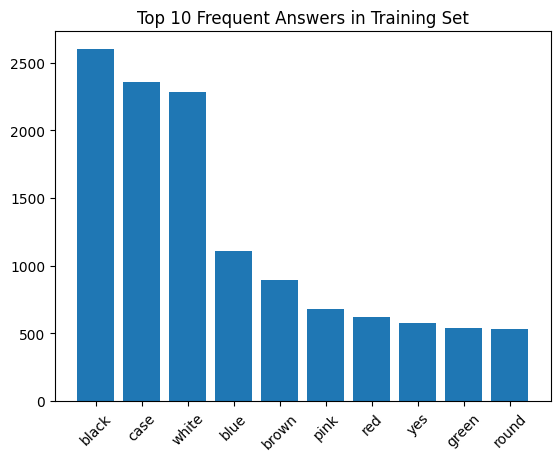

In [500]:
from collections import Counter
import matplotlib.pyplot as plt

counts = Counter(train_df['answer'])
most_common = counts.most_common(10)
print("Most common answers:", most_common)

# Optional: visualize
plt.bar(*zip(*most_common))
plt.xticks(rotation=45)
plt.title("Top 10 Frequent Answers in Training Set")
plt.show()
